In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import zipfile
import os
import datetime
import socket

IS_LOCAL = socket.gethostname() in ('gabriel-notebook', 'node13-ccncluster')

if not IS_LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')

if not IS_LOCAL and not os.path.exists('.unpacked'):
    print('Unpacking')
    with zipfile.ZipFile('conadcomplete.zip') as z:
        z.extractall()
    with open('.unpacked', 'w') as flag:
        flag.write(datetime.datetime.now().isoformat())

import json
import datetime
import baseline
from pprint import pprint as pp
from encoder import *
from baseline import *
from decoder import *
from alphabet import *
from data import *
from train import *
from simulation import *
from util import *
from models import *
from adapter import *
from user import *
from oneshot import *
from abbreviator import *
from slack import *
import torch
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 10**3)

torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment variable SLACK_WEBHOOK_URL not set: Slack messages will not be sent.


'1.4.0'

In [3]:
LANGUAGE = 'Python'

ds = load_dataset('large')[LANGUAGE]
print(len(ds['train']), 'LoC in training set')

def load_json(path):
    with open(path) as f:
        return json.load(f)

interactions = load_json('interactions.json')
user_inputs = [it for it in interactions if it['type'] == 'user_input']
conventions = [(it['long'], it['short']) for it in interactions if it['type'] == 'convention']

719723 LoC in training set


In [6]:
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
print(device)

alphabet = AsciiOneHotEncoding(device)
encoder = baseline.UniformEncoder(0.7)
decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512)

encoder, decoder, alphabet, lang_name, loss_history = load_model((encoder, 0.0005, 'large', 'python'), device=device)

cpu


In [90]:
def run_experiment(name, parameters):
    u = User()
    adapter = ModelAdapter(u, encoder, decoder, alphabet, ds['train'], parameters)
    p = Progress(sum(1 for it in interactions if it['type'] == 'user_input'))

    print('Running', name)
    
    for i, it in enumerate(interactions):
        if it['type'] != 'user_input':
            continue
        long, short = it['long'], it['short']
        adapter.run_on_example(long, short)
        p.tick()

        if (i + 1) % 100 == 0:
            print(p.format())
    
    prefix = '/content/drive/My Drive/Colab/' if not IS_LOCAL else ''
    
    with open(prefix + name + '.json', 'w') as out:
        json.dump(adapter.interaction_history, out)

def get_user_inputs_using_convention(convention_id):
    return [(it['short'], it['long']) for it in user_inputs if convention_id in it['conventions']]
        
def get_interactions_using_convention(interaction_history, convention_id):
    return [it for it, pit in zip(interaction_history, user_inputs)
            if convention_id in pit['conventions']]

def get_convention(convention_id):
    last_id = -1
    
    for it in interactions:
        if it['type'] == 'convention':
            last_id += 1
            if last_id == convention_id:
                return (it['short'], it['long'])

In [ ]:
run_experiment("baseline", {'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3})
run_experiment("dp", {100, 'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3, 'enable_divergence_prior': True})
run_experiment("lh", {'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3, 'enable_local_rehearsal': True})
run_experiment("dp+lh", {'learning_rate': 1e-3, 'divergence_prior_weight': 1e-3, 'enable_divergence_prior': True, 'enable_local_rehearsal': True})

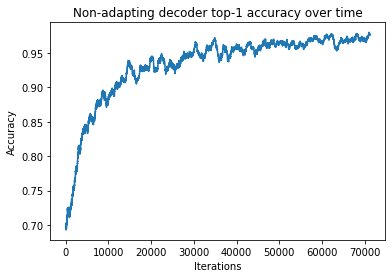

In [20]:
plt.title("Non-adapting decoder top-1 accuracy over time")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(rolling_average(correct, 1000))
plt.savefig('nonadapting.png')

# Adapt to one example

In [171]:
def adapt_until_correct(parameters, encoder, decoder, alphabet, enc, dec, test, verbose=False):
    adapter = ModelAdapter(User(), encoder, decoder, alphabet, ds['train'], parameters)
    iterations = 0

    LIMIT = 100

    for i in range(LIMIT):
        success = adapter.run_on_example(dec, enc)
        if success:
            break
        if verbose:
            print(adapter.interaction_history[-1])

    if verbose:
        print('Iterations needed to solve "{}" -> "{}": {}'.format(
              enc, dec, i if success else ('> ' + str(LIMIT))))
    
    before = adapter.prior_decoder([test], alphabet)[0]
    after = adapter.adapted_decoder([test], alphabet)[0]

    return i, (before, after)

In [172]:
CONVENTION_ID = 50
EXAMPLE_INDEX = 20

enc, dec = ("self.rq = None", "self.request = None") # get_user_inputs_using_convention(CONVENTION_ID)[EXAMPLE_INDEX]
test = ("self.parameter = some_rq")
short, long = ("rq", "request") # get_convention(CONVENTION_ID)

print('Convention', short, '=>', long)
print('Example: ', enc, '=>', dec)

adapt_until_correct({'enable_adaptation': True, 'learning_rate': 1e-2},
                    encoder, decoder, alphabet, enc, dec, test, verbose=True)

Convention rq => request
Example:  self.rq = None => self.request = None
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
InteractionLog(line='self.request = None', encoded='self.rq = None', decoded='self.req = None')
Iterations needed to solve "self.rq = None" -> "self.request = None": 4


(4, ('self.parameter = some_req', 'self.parameter = some_req'))


# One-shot learning

### Analysis on a few examples

This is just to play with learning from one example, no systematic evaluation here.

In [194]:
PARAMETERS = {'enable_adaptation': True, 'learning_rate': 1e-2}

CONVENTIONS = [
    # short, long, example_short, example_long, test_short, test_long
    ("rq", "request", "self.rq = rq", "self.request = request", "something = my_rq", "something = my_request"),
    ("ospj", "os.path.join", "path = ospj(some_list)", "path = os.path.join(some_list)", "ospj(x, y)", "os.path.join(x, y)"),
    ("npa", "np.array", "arr = npa(arr)", "arr = np.array(arr)", "np.dot(npa(x), y)", "np.dot(np.array(x), y)"),
    ("mpl", "matplotlib", "from matplotlib import pyplot as plt", "from mpl import pyplot as plt",
     "mpl.rcParams = None", "matplotlib.rcParams = None"),
]

table = []

for short, long, example_short, example_long, test_short, test_long in CONVENTIONS:
    iterations, (test_before, test_after) = adapt_until_correct(PARAMETERS, encoder, decoder, alphabet, enc, dec, test_short)
    
    table.append(("{} => {}".format(short, long),
                  "{} => {}".format(example_short, example_long),
                  "{} => {}".format(test_short, test_long),
                  iterations,
                  test_before,
                  test_after,
                  test_after == test_long))
    
pd.DataFrame(table, columns=("Expansion", "Train", "Test", "Iter.", "Test before", "Test after", "Correct?"))

,Expansion,Train,Test,Iter.,Test before,Test after,Correct?
0,rq => request,self.rq = rq => self.request = request,something = my_rq => something = my_request,6,something = my_req,something = my_req,False
1,ospj => os.path.join,path = ospj(some_list) => path = os.path.join(...,"ospj(x, y) => os.path.join(x, y)",4,"os.path.join(x, y)","os.path.join(x, y)",True
2,npa => np.array,arr = npa(arr) => arr = np.array(arr),"np.dot(npa(x), y) => np.dot(np.array(x), y)",5,"np.dot(npath(x), y)","np.dot(np.array(x), y)",True
3,mpl => matplotlib,from matplotlib import pyplot as plt => from m...,mpl.rcParams = None => matplotlib.rcParams = None,4,smpl.rcParams = None,templ.recvParams = None,False


In [ ]:
adapt_until_correct({})

In [72]:
pd.DataFrame(get_user_inputs_using_convention(50))

,0,1
0,def nb_backers(proect_page):,def nb_backers(project_page):
1,"url='https://github.com/firedrakeproect/pybench',",url='https://github.com/firedrakeproject/pyben...
2,pafy_obect = pafy.new(url),pafy_object = pafy.new(url)
3,propose = propose['reect-reason'],propose = propose['reject-reason']
4,ObectContainer.title1 = PLUGIN_TITLE,ObjectContainer.title1 = PLUGIN_TITLE
...,...,...
358,c.obect_id = fields['map_items'][0],c.object_id = fields['map_items'][0]
359,"'proect_manager_id': proect.proect_manager_id,","'project_manager_id': project.project_manager_id,"
360,"'proects',","'projects',"
361,p8_1 = ObectProperty(None),p8_1 = ObjectProperty(None)


### One-shot learning experiments

In [17]:
# Load the dataset
oneshot_dataset = load_json('oneshot_dataset.json')
print(len(oneshot_dataset), 'one-shot examples.')

oneshot_dataset = [row for row in oneshot_dataset
                   if min(len(set(row['positive_examples'])), len(set(row['negative_examples']))) >= 100]

print(len(oneshot_dataset), " usable examples.")

def run_oneshot_experiment(evaluators, learner_creators, examples=None, save=True, save_examples=False):
    d = oneshot_dataset[:(examples or len(oneshot_dataset))]
    all_results = []
    
    for e in evaluators:
        learners = [f() for f in learner_creators]

        for l in learners:
            results = e.evaluate(l, d, save_examples=save_examples)
            all_results.append({
                'evaluator': e.name(),
                'learner': l.name(),
                'results': results,
            })
            print(e.name(), e.name(), 'positive accuracy:', results['accuracy_positive'])
    
    if save:
        with open('results/oneshot_experiment_results_{}.json'
                  .format(datetime.datetime.now().isoformat()), 'w') as f:
            json.dump(all_results, f)
    return all_results

def get_best_result_by_metric(results, metric):
    best_learner, best_value = None, None
    
    for r in results:
        if best_value is None or r['results'][metric] > best_value:
            best_value = r['results'][metric]
            best_learner = r['learner']
            
    return best_learner, best_value

def summarize_results(results):
    return '\n'.join(
        '{}/{}: {:.2f}% positive accuracy, {:.2f}% negative accuracy'
        .format(r['evaluator'], r['learner'], 100*r['results']['accuracy_positive'], 100*r['results']['accuracy_negative'])
        for r in results
    )

10000 one-shot examples.
10000  usable examples.


In [19]:
EXAMPLES = 2

def new_k_gradient_steps(k, lr):
    return lambda: KGradientSteps(decoder, alphabet, {'k': k, 'learning_rate': lr})

def new_step_until_correct(max_steps, extra_steps, lr, data_augmentation, rehearsal_examples):
    return lambda: StepUntilCorrect(decoder, alphabet, {'max_steps': max_steps,
                                                        'extra_steps': extra_steps,
                                                        'learning_rate': lr,
                                                        'data_augmentation': data_augmentation,
                                                        'rehearsal_examples': rehearsal_examples}, oneshot_dataset)

evaluators = [LearnAllThenEval()] #, LearnEvalIterate()

learners = [
    #lambda: PriorBaseline(decoder, alphabet),
]

for lr in [0.1]:
    # learners.append(new_k_gradient_steps(5, lr))
    for max_steps in [4]:
        for extra in (4,):
            for augmentation in ('fetch_examples', 'ast_only_short'):
                learners.append(new_step_until_correct(max_steps, extra, lr, augmentation, 16))
try:
    results = run_oneshot_experiment(evaluators, learners, EXAMPLES, save_examples=True)
    best_learner, best_pos_acc = get_best_result_by_metric(results, 'accuracy_positive')
    send_message('One-shot new data augmentation experiment finished. Best positive accuracy: {:.2f}% (model: {}). All results:\n\n{}'
                  .format(100*best_pos_acc, best_learner, summarize_results(results)))
except Exception as e:
    send_message('Error during grid search: ' + str(e))
    raise

Batch: [("'passwordsr, [], {'max_length': '128'}),", "'password': ('django.db.models.fields.CharField', [], {'max_length': '128'}),"), ('/usr/bin/ovs-vsctl add-port vmbr0 $1 tag=%d', '/usr/bin/ovs-vsctl add-port vmbr0 $1 tag=%d'), ('def copy_song(src,f):', 'def copy_song(src,f):'), ('3PBdszhMDpXG4+kCj/nX7QUQrt7esr+YCVx8UBWauH/wJfMIT48czWOL+GGB57MICaAoOQx8ns+c', '3PBdszhMDpXG4+kCj/nX7QUQrt7esr+YCVx8UBWauH/wJfMIT48czWOL+GGB57MICaAoOQx8ns+c'), ('bytesread = self.sock.recv(2**16)', 'bytesread = self.sock.recv(2**16)'), ('src, dst = to_rect(src), to_rect(dst)', 'src, dst = to_rect(src), to_rect(dst)'), ('@type complete_sep: _sre.SRE_Pattern', '@type complete_sep: _sre.SRE_Pattern'), ('src_file_list.append(os.path.join(src_file, file_name))', 'src_file_list.append(os.path.join(src_file, file_name))'), ('src=escape(self.src()),', 'src=escape(self.src()),'), ('if symlinks and os.path.islink(srcname):', 'if symlinks and os.path.islink(srcname):'), ("if src_dir.endswith('-bin'):", "if src_dir.en

LearnAllThenEval LearnAllThenEval positive accuracy: 0.0
Batch: [("'passwordsr, [], {'max_length': '128'}),", "'password': ('django.db.models.fields.CharField', [], {'max_length': '128'}),"), ('sr', 'models.fields.CharField'), ('s', 'db.models.fields'), ('max', 'max'), ('max_length', 'max_length'), ("': '", "': '"), ('128', '128'), ('r', 'CharField'), ('s', 'models'), ('_length', '_length'), ('_', '_'), ('password', 'password'), ('s', 'models.fields'), ('s', 'django.db.models'), ('length', 'length'), ('s', 'db.models'), ('r', 'fields.CharField'), ('max_', 'max_'), (", [], {'", "', [], {'"), ('s', 'django.db.models.fields'), ('sr', 'db.models.fields.CharField'), ('sr', 'django.db.models.fields.CharField')]
Batch: [("'office_phonesr, [], {'max_length': '50'}),", "'office_phone': ('django.db.models.fields.CharField', [], {'max_length': '50'}),"), ('office_', 'office_'), ('50', '50'), ('office', 'office'), ('phone', 'phone'), ('r', 'CharField'), ('s', 'models'), ('office_phone', 'office_ph

KeyboardInterrupt: 

# Analyze interaction history

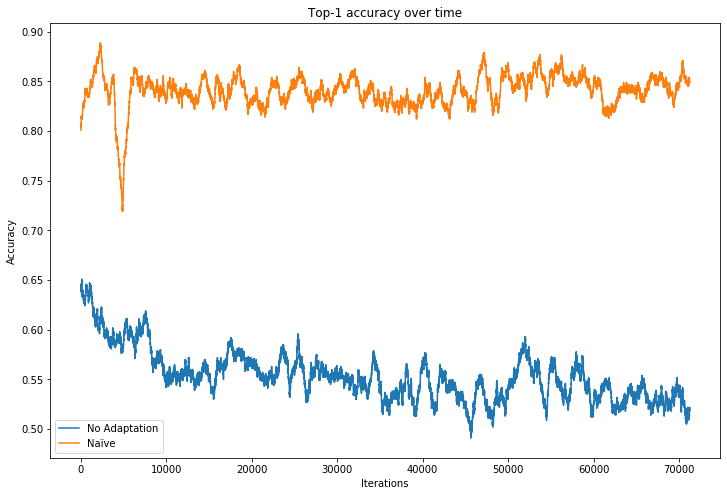

In [122]:
interaction_histories = {
    'none': ("No Adaptation", load_json('results/nonadapting.json')),
    'baseline': ("Naïve", load_json('results/baseline.json')),
#    'dp': ("DP", load_json('results/dp.json')),
#    'lh': ("LH", load_json('results/lh.json')),
#    'dp+lh': ("DP + LH", load_json('results/dp+lh.json')),
}

def plot_accuracy(plot_id, title_suffix, models, window_size=1000):    
    plt.title("Top-1 accuracy over time" + title_suffix)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")

    for model, (name, interaction_history) in models.items():
        correct = [original == dec for original, _, dec in interaction_history]
        plt.plot(rolling_average(correct, window_size), label=name)
    
    plt.legend()
    plt.savefig('figures/accuracy-' + plot_id + '.png')
    plt.show()
    
plot_accuracy("global", "", interaction_histories)

In [130]:
def plot_average_conventions(window_size=100):
    number_of_conventions_applied = [len(it['conventions']) for it in interactions if it['type'] == 'user_input']
    plt.title("Average number of conventions used per user input")
    plt.xlabel("Iterations")
    plt.ylabel("Average conventions used")
    plt.plot(rolling_average(number_of_conventions_applied, window_size))
    plt.savefig('figures/avg-conventions-used.png')
    plt.show()

    
def plot_accuracy_by_convention(convention_id, window_size=100):
    models = {
        model_id: (title, get_interactions_using_convention(interaction_history, convention_id))
        for model_id, (title, interaction_history) in interaction_histories.items()
    }
    n_interactions = len(list(models.items())[0][1][1])
    fraction = n_interactions / len(list(interaction_histories.items())[0][1][1])
    plot_accuracy("conv-{}".format(convention_id), 
                  "[[ {} -> {} ]] ({:.2f}% coverage)".format(*get_convention(convention_id), 100*fraction),
                  models,
                  window_size)
    return

    for model_id, (model_title, interaction_history) in interaction_histories.items():
        relevant_interactions = get_interactions_using_convention(interaction_history, convention_id)
        fraction = len(relevant_interactions) / len(interaction_history)
        plot_accuracy("{}-conv{}".format(model_id, convention_id),
                      "{} on [[ {} -> {} ]] ({:.2f}% coverage)".format(model_title, *get_convention(convention_id), 100*fraction),
                      relevant_interactions,
                      window_size)


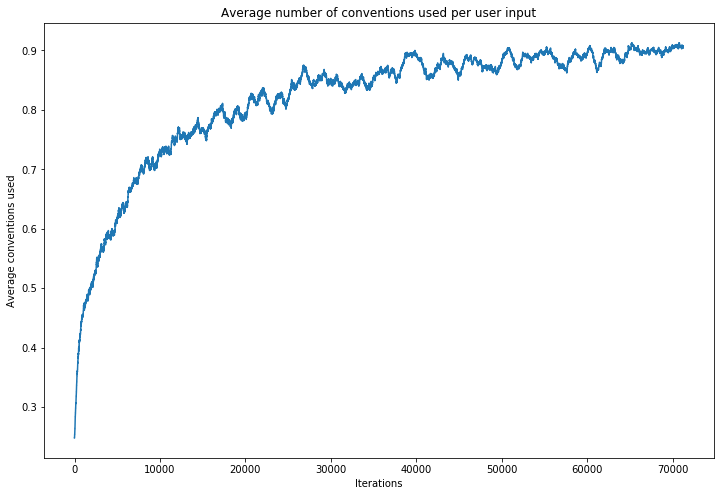

In [124]:
plot_average_conventions(1000)

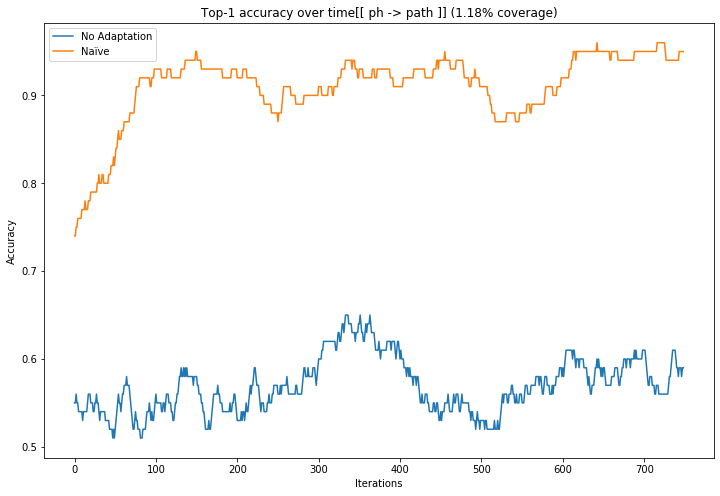

In [138]:
CONVENTION_ID = 12

plot_accuracy_by_convention(CONVENTION_ID, 100)

# Error analysis for one-shot learning scenario

In [6]:
RESULTS_PATH = 'results/oneshot_experiment_results_2020-04-14T11:54:12.067527.json'

with open(RESULTS_PATH) as f:
    results = json.load(f)

print('Loaded results for', len(results), 'learner/evaluator pairs.')

Loaded results for 20 learner/evaluator pairs.


### Best models by some metric

In [19]:
FILTER_EVALUATOR = None
SORT_BY='Positive Accuracy'

pd.DataFrame(
    [
        (r['evaluator'],
         r['learner'],
         r['results']['accuracy'],
         r['results']['accuracy_positive'],
         r['results']['accuracy_negative'])
        for r in results
    ],
    columns=('Evaluator', 'Learner', 'Accuracy', 'Positive Accuracy', 'Negative Accuracy'),
).sort_values(SORT_BY, ascending=False)

,Evaluator,Learner,Accuracy,Positive Accuracy,Negative Accuracy
11,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=16, extra=2, data_augmentation=only_short, reheasal_examples=0)",0.281710,0.222221,0.333190
17,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=32, extra=2, data_augmentation=only_short, reheasal_examples=0)",0.249687,0.207656,0.285972
14,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=32, extra=2, data_augmentation=no, reheasal_examples=0)",0.209500,0.198524,0.221237
1,LearnEvalIterate,"KGradientSteps(K=5, lr=0.1)",0.256412,0.198027,0.308369
18,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=32, extra=2, data_augmentation=only_short, reheasal_examples=16)",0.282467,0.176281,0.375622
2,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=no, reheasal_examples=0)",0.184048,0.162393,0.204300
5,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=only_short, reheasal_examples=0)",0.207321,0.148396,0.259919
19,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=32, extra=2, data_augmentation=only_short, reheasal_examples=32)",0.265767,0.129164,0.385528
12,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=16, extra=2, data_augmentation=only_short, reheasal_examples=16)",0.271144,0.122109,0.401891
15,LearnEvalIterate,"StepUntilCorrect(lr=0.1, max=32, extra=2, data_augmentation=no, reheasal_examples=16)",0.234110,0.084235,0.365405


### Evaluate a single model

In [118]:
[r['learner'] for r in results]

['PriorBaseline',
 'KGradientSteps(K=5, lr=0.1)',
 'StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=no, reheasal_examples=0)',
 'StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=no, reheasal_examples=16)',
 'StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=no, reheasal_examples=32)',
 'StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=only_short, reheasal_examples=0)',
 'StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=only_short, reheasal_examples=16)',
 'StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=only_short, reheasal_examples=32)',
 'StepUntilCorrect(lr=0.1, max=16, extra=2, data_augmentation=no, reheasal_examples=0)',
 'StepUntilCorrect(lr=0.1, max=16, extra=2, data_augmentation=no, reheasal_examples=16)',
 'StepUntilCorrect(lr=0.1, max=16, extra=2, data_augmentation=no, reheasal_examples=32)',
 'StepUntilCorrect(lr=0.1, max=16, extra=2, data_augmentation=only_short, reheasal_examples=0)',
 'StepUntilCorrect(lr=0.1, m

In [123]:
(evaluator, learner) = ('LearnEvalIterate', 'StepUntilCorrect(lr=0.1, max=32, extra=2, data_augmentation=no, reheasal_examples=0)')
(evaluator, learner) = ('LearnEvalIterate', 'StepUntilCorrect(lr=0.1, max=8, extra=2, data_augmentation=no, reheasal_examples=0)')

result = [r for r in results if (r['evaluator'], r['learner']) == (evaluator, learner)][0]['results']

#### Accuracy over time

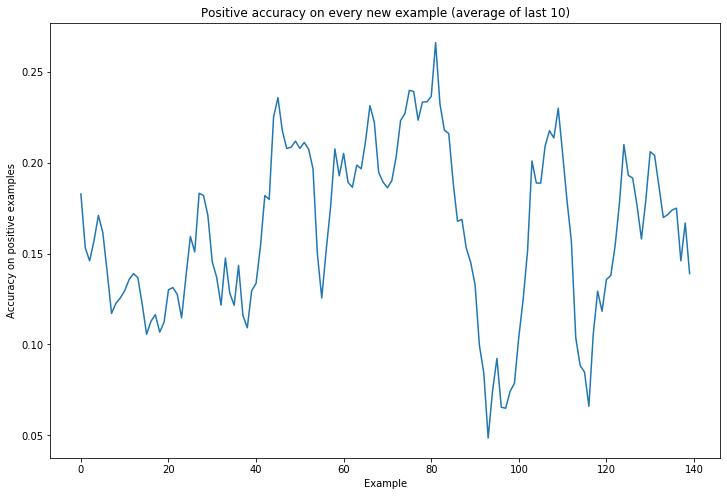

In [124]:
plt.title("Positive accuracy on every new example (average of last 10)")
plt.xlabel('Example')
plt.ylabel('Accuracy on positive examples')
plt.plot(rolling_average(result['per_example_accuracy_positive'], 10))

#### Accuracy by abbreviation

In [76]:
SORT_BY='Positive Accuracy'

accuracy_by_abbreviation = list(zip(oneshot_dataset, result['per_example_accuracy_positive']))

pd.DataFrame([
    (i,
     abbrev['abbreviation'],
     abbrev['string'],
     acc)
    for (i, (abbrev, acc)) in enumerate(accuracy_by_abbreviation)
],
    columns=('Index', 'Abbreviation', 'Full string', 'Positive Accuracy'),
).sort_values(SORT_BY)

,Index,Abbreviation,Full string,Positive Accuracy
0,0,b.C,': ('django.db.models.fields.CharField',0.000000
13,13,PI,WSGI_APPLICATION = ',0.000000
83,83,ut,@app.route('/,0.000000
98,98,or,", action='store",0.000000
24,24,tt,'https://github.com/,0.005025
78,78,ER,SECRET_KEY = ',0.005263
148,148,s,= sys.argv[1],0.006250
146,146,ma,.format(self.,0.010050
124,124,te,.connect(self.,0.010152
48,48,je,.objects.filter(,0.010417


#### Examples by abbreviation

In [77]:
INDEX = 52
INCLUDE_POSITIVE = True
INCLUDE_NEGATIVE = False
SHOW_CATEGORY = True
SHOW_ANSWER = True
SHOW_PREDICTION = True

abbreviation = oneshot_dataset[INDEX]
examples = ((abbreviation['positive_examples'] if INCLUDE_POSITIVE else []) +
            (abbreviation['negative_examples'] if INCLUDE_NEGATIVE else []))

model_examples = [r for r in result['examples'] if r['long'] in examples and r['short'].find(abbreviation['abbreviation']) != -1]

print('Abbreviation {}: "{}" ==> "{}"'.format(INDEX, abbreviation['abbreviation'], abbreviation['string']))
print('Positive Accuracy: {:.2f}%'.format(100*result['per_example_accuracy_positive'][INDEX]))

pd.DataFrame([
    (
        repr(example['short']),
        repr(example['long']) if SHOW_ANSWER else '<<hidden>>',
        repr(example['prediction']) if SHOW_PREDICTION else '<<hidden>>',
        ('Negative', 'Positive')[example['long'] in abbreviation['positive_examples']] if SHOW_PREDICTION else '<<hidden>>',
        (example['long'] == example['prediction']) if SHOW_PREDICTION else '<<hidden>>',
    )
    for example in model_examples
],
    columns=('Short', 'Original', 'Prediction', 'Class', 'Correct?')
)

Abbreviation 52: " t" ==> "= random.randint("
Positive Accuracy: 56.12%


,Short,Original,Prediction,Class,Correct?
0,"'random_index t0, len(possible_votes) - 1)'","'random_index = random.randint(0, len(possible_votes) - 1)'",'random_index = random.randint(possible_votes) - 1)',Positive,False
1,"'nclients t0, 9)'","'nclients = random.randint(0, 9)'","'nclients = random.randint(0, 9)'",Positive,True
2,"'z t0, 5)'","'z = random.randint(0, 5)'","'z = random.randint(0, 5)'",Positive,True
3,"'rand_int t0,1)'","'rand_int = random.randint(0,1)'","'rand_int = random_int(0,1)'",Positive,False
4,"'x t0, SCREEN_WIDTH-1)'","'x = random.randint(0, SCREEN_WIDTH-1)'","'x = random.randint(0, SCREEN_WIDTH-1)'",Positive,True
5,"'modifier t1,6)+random.randint(1,6)'","'modifier= random.randint(1,6)+random.randint(1,6)'","'modifier = random.randint(1,6)'",Positive,False
6,"'iceX t300, 400)'","'iceX = random.randint(300, 400)'","'iceX = random.randint(300, 400)'",Positive,True
7,"'period t1,5)'","'period = random.randint(1,5)'","'period = random.randint(1,5)'",Positive,True
8,"'x,y t0,5), random.randint(0,5)'","'x,y = random.randint(0,5), random.randint(0,5)'","'x,y = random.randint(0,5)'",Positive,False
9,"'startYear t2000,2013)'","'startYear = random.randint(2000,2013)'","'startYear = random.randint(2000,2013)'",Positive,True


### Compare two models

In [113]:
(evaluator1, learner1) = ('LearnEvalIterate', 'StepUntilCorrect(lr=0.1, max=16, extra=2, data_augmentation=only_short, reheasal_examples=0)')
(evaluator2, learner2) = ('LearnEvalIterate', 'StepUntilCorrect(lr=0.1, max=32, extra=2, data_augmentation=no, reheasal_examples=0)')

result1 = [r for r in results if (r['evaluator'], r['learner']) == (evaluator1, learner1)][0]['results']
result2 = [r for r in results if (r['evaluator'], r['learner']) == (evaluator2, learner2)][0]['results']

In [115]:
result2['accuracy_positive']

0.19852418630798008

#### Difference in accuracy between both models for each abbreviation

In [95]:
SORT_BY='Difference'

accuracy_by_abbreviation = list(zip(oneshot_dataset,
                                    result1['per_example_accuracy_positive'],
                                    result2['per_example_accuracy_positive']))

pd.DataFrame([
    (i,
     abbrev['abbreviation'],
     abbrev['string'],
     acc1,
     acc2,
     acc1 - acc2)
    for (i, (abbrev, acc1, acc2)) in enumerate(accuracy_by_abbreviation)
],
    columns=('Index', 'Abbreviation', 'Full string', 'Positive Accuracy (model 1)', 'Positive Accuracy (model 2)', 'Difference'),
).sort_values(SORT_BY)

,Index,Abbreviation,Full string,Positive Accuracy (model 1),Positive Accuracy (model 2),Difference
83,83,ut,@app.route('/,0.000000,0.537313,-0.537313
127,127,me,= time.time(),0.070866,0.488189,-0.417323
1,1,rd_s,return render_to_response(,0.011111,0.322222,-0.311111
148,148,s,= sys.argv[1],0.006250,0.312500,-0.306250
72,72,if,"__init__(self, f",0.060811,0.364865,-0.304054
85,85,s(,= requests.get(,0.022599,0.293785,-0.271186
13,13,PI,WSGI_APPLICATION = ',0.000000,0.237805,-0.237805
12,12,re,for i in range(len(,0.165803,0.305699,-0.139896
110,110,t,__author__ = ',0.122449,0.255102,-0.132653
125,125,el,return self.c,0.038251,0.169399,-0.131148


# "Efficient Python"

Experiments where the system tries to find short and accurate abbreviations for Python.

In [15]:
def run_abbreviator_experiment(targets, abbreviators):
    print(len(ds['dev']), 'examples in the validation set.')

    results = {}
    evaluator = AbbreviatorEvaluator(targets, ds['dev'][:5])
    summary = ''
    p = Progress(len(abbreviators) * len(targets), print_every=5)

    for ab in abbreviators:
        print('Evaluating', ab.name())
        results[ab.name()] = evaluator.evaluate(ab)
        summary += ('{} - accuracy: {:.2f}%, compression: {:.2f}%, abbreviation compression: {:.2f}%\n'
                    .format(ab.name(),
                            100*results['accuracy'], 
                            100*results['eval_compression'],
                            100*results['abbreviation_compression']))

    path = 'results/abbreviator_experiment_{}.json'.format(datetime.datetime.now().isoformat())

    with open(path, 'w') as f:
        json.dump(results, f)
        
    send_message('Language Abbreviator ({} abbreviations) experiment finished. Results saved to {}. Summary: \n{}'
                 .format(len(targets), path, summary))
    
def trim_to_id(s):
    first_id, last_id = None, None
    
    for i, c in enumerate(s):
        if c.isidentifier():
            if first_id is None:
                first_id = i
            last_id = i

    if first_id is None:
        return None
    return s[first_id:(last_id + 1)]
    
def build_targets(n_abbreviations):
    seen = set()
    chosen_targets = []
    for row in oneshot_dataset:
        t = trim_to_id(row['string'])
        if t is not None and t not in seen:
            seen.add(t)
            chosen_targets.append(t)
            if len(chosen_targets) == n_abbreviations:
                break
    return chosen_targets        

In [47]:
run_abbreviator_experiment(
    build_targets(2),
    [
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.1, 'rehearsal_batch_size': 0}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.01, 'rehearsal_batch_size': 0}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.1, 'rehearsal_batch_size': 32}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.01, 'rehearsal_batch_size': 32}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.1, 'rehearsal_batch_size': 64}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.01, 'rehearsal_batch_size': 64}),
        
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.1, 'rehearsal_batch_size': 0, 'minimum_validation_accuracy': 0.9}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.01, 'rehearsal_batch_size': 0, 'minimum_validation_accuracy': 0.9}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.1, 'rehearsal_batch_size': 32, 'minimum_validation_accuracy': 0.9}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.01, 'rehearsal_batch_size': 32, 'minimum_validation_accuracy': 0.9}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.1, 'rehearsal_batch_size': 64, 'minimum_validation_accuracy': 0.9}),
        LanguageAbbreviator(decoder, alphabet, ds['train'], {'learning_rate': 0.01, 'rehearsal_batch_size': 64, 'minimum_validation_accuracy': 0.9}),
    ][:1]
)

90119 examples in the validation set.
Evaluating LanguageAbbreviator(min_val_acc=0.80, min_train=64, val_ex=32, lr=0.1, max_steps=100)
Trying to abbreviate 'django.db.models.fields.CharField'
Val accuracy with django.db.models.fields.CharField => django.db.models.fields.CharField after 1 steps: 0.91
Val accuracy with django.db.models.fields.CharField => django.db.models.fields.CharField after 1 steps: 0.91
Val accuracy with django.db.models.fields.CharFiel => django.db.models.fields.CharField after 1 steps: 0.91
Val accuracy with django.db.models.fields.CharFie => django.db.models.fields.CharField after 1 steps: 0.91


KeyboardInterrupt: 